# OpSim -- simulation

## About

This notebook is for testing of the OpSim functionality.
An attempt was made to simplify code, so in most cases we
rely on the precalculated Sun trajectory and the solar
panel power output profile, loaded from files.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility

import numpy as np
import matplotlib.pyplot as plt
import simpy


In [8]:
# Load lusee and OpSim

import  lusee
from    nav        import * # includes luseepy
from    bms.parts  import * # Battery
from    bms.panels import *
from    bms.controller import *
from    bms.battery import *
# ----------------------------------------------------
print(f'''simpy version: {simpy.__version__}''')
print(f'''lusee version: {lusee.__version__}''')


simpy version: 4.0.2
lusee version: 1.2-dev


---

In the following, we have an option to read:
* _prefab data for the Sun trajectory_
* precalculated _panel power output profile_.


In [3]:
# Read the prefab data on sun trajectory
import os
from nav import Sun
print('Current directory:', os.getcwd())

mySun = Sun()

cachefile = '../data/2025-02-04_03-07.npy'
mySun.read(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')

sun = mySun.xyz # altaz2xyz(mySun.alt, mySun.az)
hrs = mySun.hrsFromSunrise()


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


---

Read the "panel exposure" i.e. the effective area as defined by the Sun position and geometry of the panels


In [4]:
import os
print('Current directory:', os.getcwd())
power_cachefile = '../data/2025-02-04_03-07_power.npy'
# with open(power_cachefile, 'rb') as f: pwr = np.load(f) #print(f'''Number of points read from the file {power_cachefile}: {pwr.size}''')

Panel.verbose = True
Panel.read_profile(power_cachefile)


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Loaded data from file "../data/2025-02-04_03-07_power.npy", number of points: 2993


---

Optionally, print out the power profile numbers to check if they make sense...

In [ ]:
# To check the numerical values -- can convert to a Python list: a = list(pwr) print(*a, sep = ", ")
# Or, print power values with the MJD timestamps:
print(f'''Will attempt to access {mySun.N} points {Panel.profile}''')
for i in range(0, mySun.N):
    print("%5.3f: %5.3f" % (mySun.mjd[i], Panel.profile[i]))


---

Read the temperature curve
* Data starts at midnight
* -6hrs to shift to hours from sunrise


In [9]:
temp_data = np.loadtxt("../reference/lunarTemperature30degDiviner.txt", delimiter=',')

time_hrs=(temp_data[:,0]-6)/24*hrs_per_lunar_day

temp=temp_data[:,1]

print(f'''Data array: {temp_data.size}, hours per lunar day: {hrs_per_lunar_day}, t_inc: {t_inc}''')


NameError: name 't_inc' is not defined

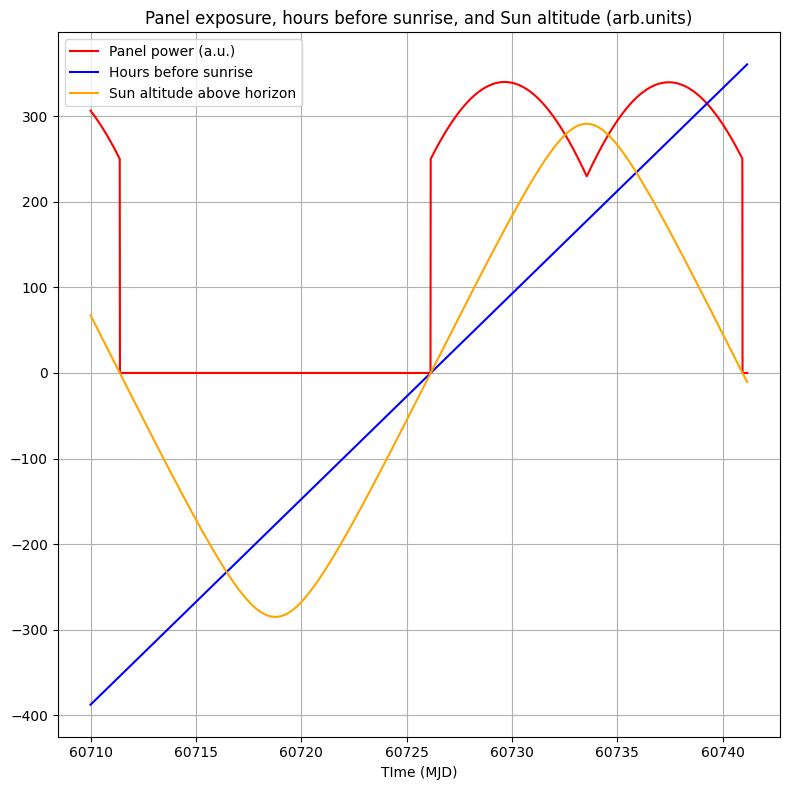

In [12]:

plt.rcParams["figure.figsize"] = [8., 8.]
# plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, Panel.profile*250., color="red",    label="Panel power (a.u.)")
ax.set_xlabel('TIme (MJD)')
ax.plot(mySun.mjd, hrs, color="blue",    label="Hours before sunrise")
ax.plot(mySun.mjd, mySun.alt*250, color="orange",  label="Sun altitude above horizon")


# --- plt.xlim(-100,400)
plt.grid(True)
plt.title("Panel exposure, hours before sunrise, and Sun altitude (arb.units)")
plt.legend()

plt.show()

---

Device properties, such as states and power consumption for each state, can be stored in a _YAML_ file and read into the application.


In [9]:
# Read device configuration
import yaml

device_file = '../config/devices.yml'
print(f'''Reading device profiles from the file "{'../config/devices.yml'}"''')
f = open(device_file, 'r')

device_data = yaml.load(f, Loader=yaml.FullLoader)
profiles    = device_data['devices']
print(profiles.keys())



Reading device profiles from the file "../config/devices.yml"
dict_keys(['controller', 'comms'])


Created a Battery with initial charge: 100.0, capacity: 1200.0
List added devices:
controller ON
comms OFF


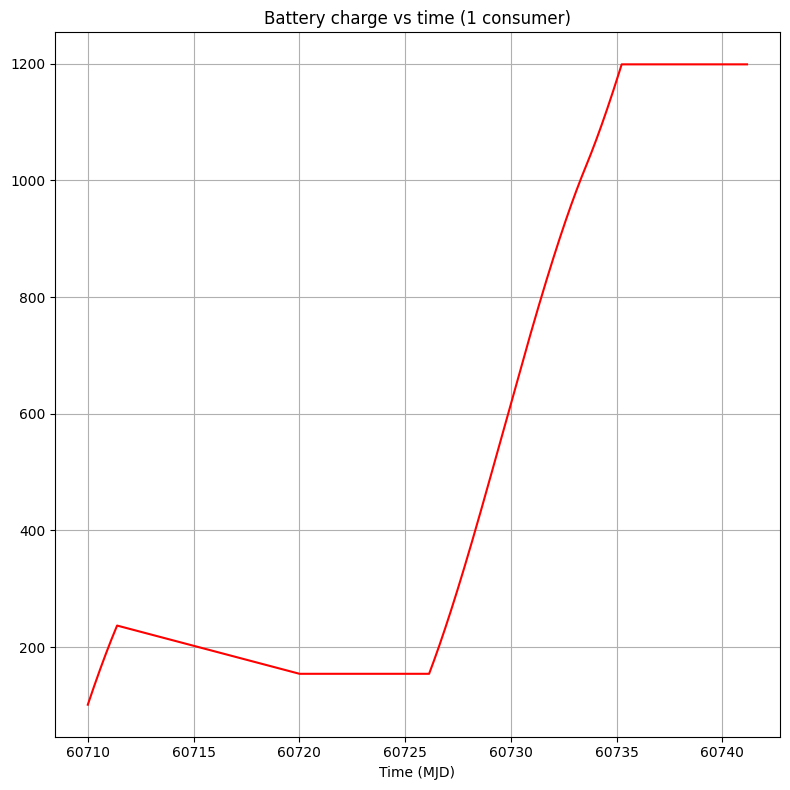

In [10]:
from    bms.battery     import *
from    bms.controller  import *
from    bms.parts       import *

env = simpy.Environment()

initial_charge, capacity = 100., 1200.

battery = Battery(env, initial_charge, capacity)

print(f'''Created a Battery with initial charge: {battery.level}, capacity: {battery.capacity}''')

mon = Monitor(mySun.N) # to define the discrete time axis
ctr = Controller(env, mySun.mjd, battery, mon)
ctr.add_all_panels(mySun)

for device_name in profiles.keys():
    device = Device(device_name, profiles[device_name])
    ctr.add_device(device)

ctr.set_device_state('controller', 'ON')

print('List added devices:')
for added_device in ctr.devices.keys():
        dvc = ctr.devices[added_device]
        print(dvc.name, dvc.state)


ctr.set_condition(mySun.condition)

env.process(ctr.run())
env.run(until=mySun.N)


plt.rcParams["figure.figsize"] = [8., 8.]
plt.rcParams["figure.autolayout"] = True
ax=plt.subplot()
ax.set_xlabel('Time (MJD)')

ax.plot(mySun.mjd, ctr.monitor.battery, color="red",    label="Panel power (a.u.)")

# --- plt.xlim(-100,400)
plt.grid(True)
plt.title("Battery charge vs time (1 consumer)")
plt.show()



